# 1. 데이터 및 기본 작업

## 1.1 라이브러리 불러오기

In [210]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from pytorchtools import EarlyStopping

## 1.2 폰트 및 함수 세팅

In [215]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [65]:
# 성능 측정 함수 
def score(actual, prediction):
    rmse = round(np.sqrt(mean_squared_error(actual, prediction)), 4)
    mae = round(mean_absolute_error(actual, prediction), 4)
    return rmse, mae

In [66]:
# 시계열 그래프 시각화 함수
def time_series_plot(time, data, title, ylab):
    
    # 그래프 크기 설정
    plt.figure(figsize=(12, 6))
    
    # 그래프 그리기
    plt.plot(time, data)
    
    # 축 이름, 글자 크기, 그리드 설정
    plt.title(title, fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('시간', fontsize=18)
    plt.ylabel(ylab, fontsize=18)
    plt.grid(True)
    plt.tight_layout()
    
    # 그래프 보이기
    plt.show()

In [67]:
# 산점도 시각화 함수
def variable_scatterplot(xlab, ylab):

    # 그림 크기 설정
    plt.figure(figsize=(8, 6))  
    
    # 산점도 그리기
    scatterplot = sns.scatterplot(x=xlab, y=ylab, data=data)

    # 축 레이블 설정
    scatterplot.set_xlabel(xlab, fontsize=18)
    scatterplot.set_ylabel(ylab, fontsize=18)
    plt.xticks(fontsize=16)  # x축 눈금 레이블의 글자 크기 설정
    plt.yticks(fontsize=16)  # y축 눈금 레이블의 글자 크기 설정
    plt.grid(True)
    
    plt.show()

In [68]:
# 결과 시각화 함수 (실제 값 vs 모델 예측 결과)
def result_plot(start, end, pivot, actual, prediction, model_name):
    time_range = pd.date_range(start=start, end=end, freq='M')
    
    # 그래프 크기 설정
    plt.figure(figsize=(12, 6))

    # 그래프 그리기
    plt.plot(time_range, actual, label='실제 값', color='black')
    plt.plot(time_range, prediction, label='예측 값', color='red')
    
    # 학습, 예축 구간 분기선
    plt.axvline(x = pd.to_datetime(pivot), color='gray', linestyle='--')
    
    # 축 제목, 크기 설정
    plt.xlabel('Time', fontsize=18)
    plt.ylabel('소비자물가지수', fontsize=18)
    plt.title(model_name + '모델', fontsize=20)
    plt.legend(fontsize=18)
    plt.grid(True)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    
    # 그래프 보이기
    plt.show()

## 1.3 데이터 불러오기

In [69]:
# 데이터 불러오기
data = pd.read_csv('data.csv')
data = data.drop(['ESI'], axis=1) # 경제심리지수(ESI)는 정의 상 다중공선성이 있으므로 제거
data.columns = ['아파트 매매 실거래가격지수', '아파트 전세가격지수', 'M1 유동성', '한국은행 기준금리', '경기선행지수'] # 열 이름 설정
data

,아파트 매매 실거래가격지수,아파트 전세가격지수,M1 유동성,한국은행 기준금리,경기선행지수
0,100.000,100.000,100.000,2.75,100.000
1,100.414,100.576,100.973,2.75,100.136
2,101.381,101.295,101.462,2.75,100.305
3,101.796,101.727,102.838,2.75,100.465
4,102.072,101.871,103.035,2.50,100.587
...,...,...,...,...,...
120,197.928,127.770,260.584,3.50,99.417
121,201.934,123.453,259.061,3.50,99.362
122,204.834,121.007,257.754,3.50,99.395
123,208.149,120.144,257.047,3.50,99.490


# 2. 탐색적 데이터 분석

## 2.1 변수의 시계열 그래프

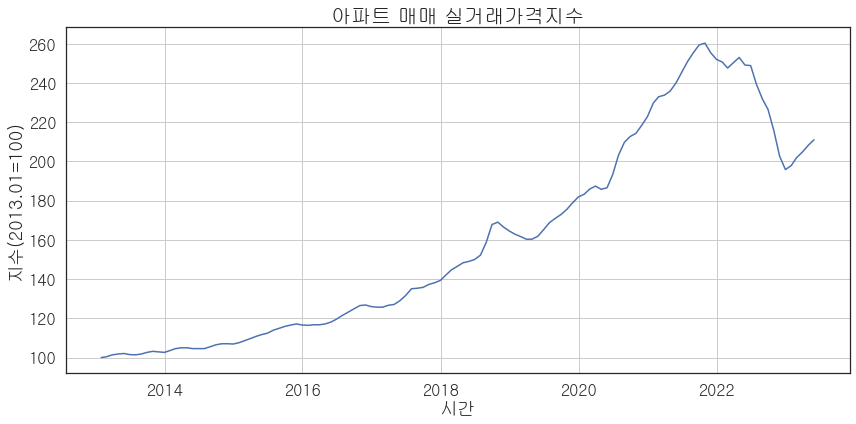

In [70]:
months = pd.date_range(start='2013-01-01', periods=len(data), freq='M')
time_series_plot(months, data['아파트 매매 실거래가격지수'], '아파트 매매 실거래가격지수', '지수(2013.01=100)')

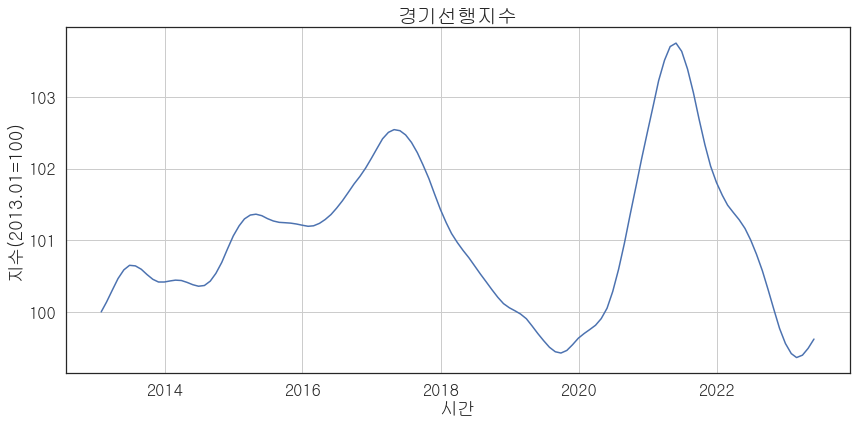

In [71]:
time_series_plot(months, data['경기선행지수'], '경기선행지수', '지수(2013.01=100)')

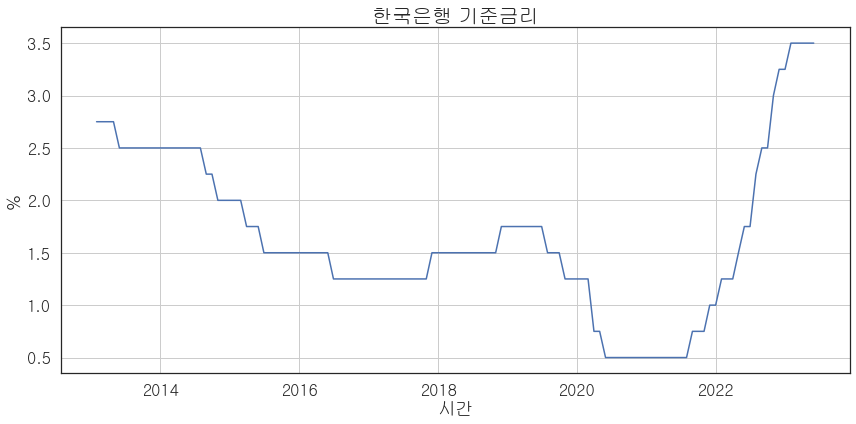

In [72]:
time_series_plot(months, data['한국은행 기준금리'], '한국은행 기준금리', '%')

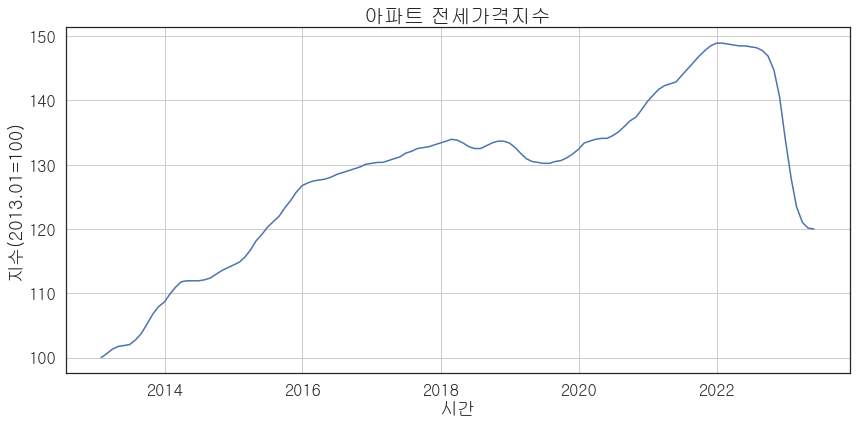

In [73]:
time_series_plot(months, data['아파트 전세가격지수'], '아파트 전세가격지수', '지수(2013.01=100)')

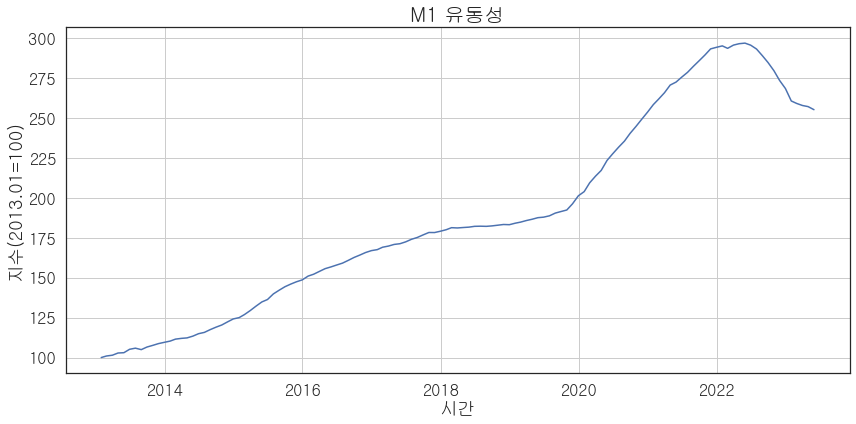

In [74]:
time_series_plot(months, data['M1 유동성'], 'M1 유동성', '지수(2013.01=100)')

## 2.2 변수 간 상관관계 확인

In [75]:
# 한 시점 미래의 아파트 매매 실거래가격지수를 종속변수로 설정
ASPI_1 = data['아파트 매매 실거래가격지수'][1:].tolist() + [np.nan] 
data['미래 아파트 매매 실거래가격지수'] = ASPI_1
data

,아파트 매매 실거래가격지수,아파트 전세가격지수,M1 유동성,한국은행 기준금리,경기선행지수,미래 아파트 매매 실거래가격지수
0,100.000,100.000,100.000,2.75,100.000,100.414
1,100.414,100.576,100.973,2.75,100.136,101.381
2,101.381,101.295,101.462,2.75,100.305,101.796
3,101.796,101.727,102.838,2.75,100.465,102.072
4,102.072,101.871,103.035,2.50,100.587,101.519
...,...,...,...,...,...,...
120,197.928,127.770,260.584,3.50,99.417,201.934
121,201.934,123.453,259.061,3.50,99.362,204.834
122,204.834,121.007,257.754,3.50,99.395,208.149
123,208.149,120.144,257.047,3.50,99.490,211.050


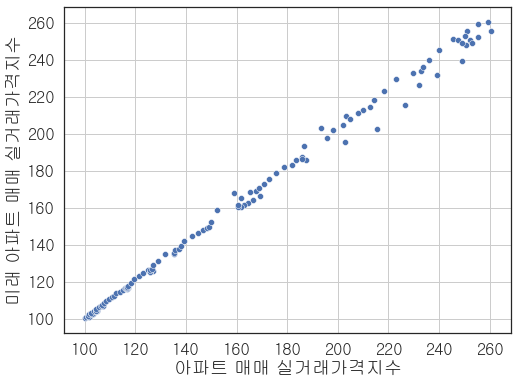

In [76]:
variable_scatterplot('아파트 매매 실거래가격지수', '미래 아파트 매매 실거래가격지수')

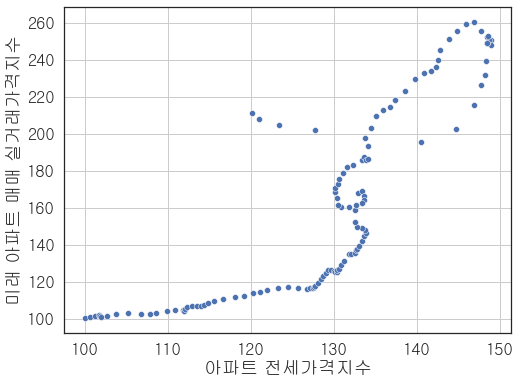

In [77]:
variable_scatterplot('아파트 전세가격지수', '미래 아파트 매매 실거래가격지수')

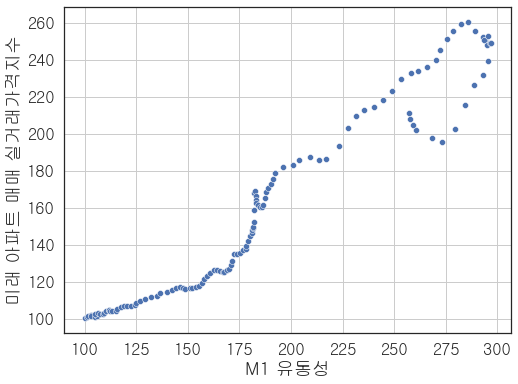

In [78]:
variable_scatterplot('M1 유동성', '미래 아파트 매매 실거래가격지수')

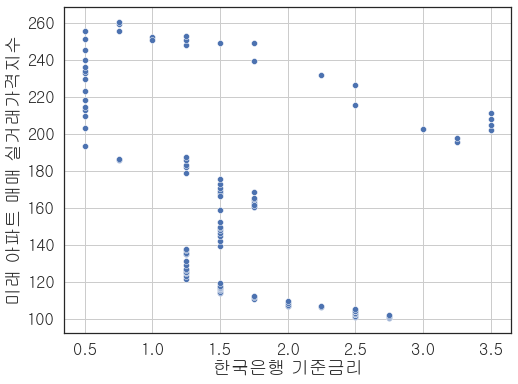

In [79]:
variable_scatterplot('한국은행 기준금리', '미래 아파트 매매 실거래가격지수')

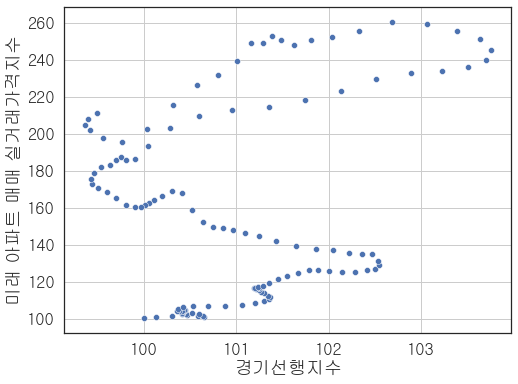

In [80]:
variable_scatterplot('경기선행지수', '미래 아파트 매매 실거래가격지수')

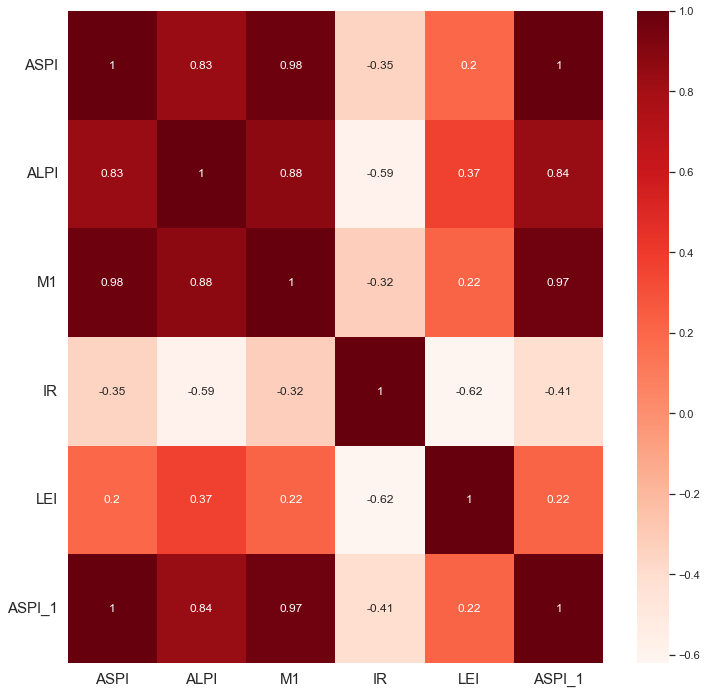

In [107]:
# 상관계수 히트맵
corr_matrix = data.corr()
sns.set(style='white')
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='Reds')
ax.set_xticklabels(['ASPI', 'ALPI', 'M1', 'IR', 'LEI', 'ASPI_1'], size=15, rotation=0)
ax.set_yticklabels(['ASPI', 'ALPI', 'M1', 'IR', 'LEI', 'ASPI_1'], size=15, rotation=0);

# 3. 모델링

* **다중선형회귀 및 ARIMA 모델은 R 코드 참조**

## 3.1 RNN
### 하이퍼파라미터 종류
* input_size: 설명변수의 개수(고정)
* sequence_length: 종속변수를 예측할 때 사용할 과거 데이터의 개수 (RNN 함수의 하이퍼파라미터는 아님)
* hidden size: hidden state(은닉 상태)에서의 변수 개수
* num_layers: recurrent layers(순환 신경망)의 개수. 예를 들어 num_layers=2 이면 순환 신경망을 2개 쌓는다는 의미

In [196]:
input_size = 4 # 설명변수의 개수(고정)

# 하이퍼파라미터 탐색
sequence_lengths_ = [3, 6, 9]
hidden_sizes_ = [2, 3, 4, 5, 6, 7, 8]
num_layers_ = [1, 2, 3, 4, 5, 6, 7, 8]

params = []

for s in sequence_lengths_:
    for h in hidden_sizes_:
        for n in num_layers_:
            params.append([s, h, n])

In [197]:
# 데이터를 시퀀스 형태로 만들어주는 함수
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length, :]  # 모든 열을 포함하는 입력 시퀀스로 사용
        target = data[i+seq_length, 0]  # 다음 행의 첫 번째 열을 타겟으로 사용
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# RNN 모델 정의
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [198]:
# 스케일링한 값을 원래 값으로 복원하기 위한 종속변수 최대, 최솟값 저장
M = max(data['아파트 매매 실거래가격지수'])
m = min(data['아파트 매매 실거래가격지수'])

In [195]:
data.drop(['경기선행지수', '미래 아파트 매매 실거래가격지수'], axis=1, inplace=True)

In [199]:
# 하이퍼파라미터 별 rmse, mae를 기록하기 위한 리스트 초기화
RMSE = []
MAE = []

# 최고 성능과 하이퍼파라미터 초기화
best_rmse = 10e9
best_params = [0, 0, 0]

for p in params:
    # 랜덤 시드 고정
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    
    seq_length, hidden_size, num_layers = p[0], p[1], p[2]

    # 학습구간, 예측구간 데이터 분리(최근 17개월 데이터 예측)
    train = data.iloc[:-17, :] 
    test = data.iloc[-17 - seq_length:, :]

    # 변수 스케일링
    Scaler = MinMaxScaler()
    train_scaled = pd.DataFrame(Scaler.fit_transform(train), columns=train.columns)
    test_scaled = pd.DataFrame(Scaler.transform(test), columns=test.columns)

    # 입력 시퀀스 데이터, 출력 데이터 생성
    sequences, targets = create_sequences(train_scaled.values, seq_length)

    # 데이터를 PyTorch Tensor로 변환
    sequences = torch.FloatTensor(sequences)
    targets = torch.FloatTensor(targets).view(-1, 1)

    # RNN 모델 선언
    model = RNN(input_size, hidden_size, num_layers)

    # 손실 함수와 옵티마이저 선언
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)

    # 과적합 방지를 위한 early stopping 함수(7번 epoch 연속으로 loss 미개선 시 조기 종료)
    early_stopping = EarlyStopping(patience = 7, verbose = False)

    # 모델 학습
    num_epochs = 1000
    for epoch in range(num_epochs):
        outputs = model(sequences)
        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        early_stopping(loss.item(), model) # 현재 과적합 상황 추적
    
        if early_stopping.early_stop: # 조건 만족 시 조기 종료
            print('종료 epoch:', epoch)
            break
    
    # test set에서의 시퀀스 생성
    test_sequences, _ = create_sequences(test_scaled.values, seq_length)
    test_sequences = torch.FloatTensor(test_sequences)
    
    # train, test 구간에서 예측값 구하기
    model.eval()
    with torch.no_grad():
        train_outputs = model(sequences)
        test_outputs = model(test_sequences)

    train_prediction = train_outputs * (M - m) + m # 스케일링 복원한 예측값(train)
    train_actual = data['아파트 매매 실거래가격지수'][seq_length:seq_length + len(train_prediction)] # 종속변수 실제 값(train)
    test_prediction = test_outputs * (M - m) + m # 스케일링 복원한 예측값(test)
    test_actual = data['아파트 매매 실거래가격지수'][-17:] # 종속변수 실제 값(test)
    
    # 학습 구간에서의 모델 성능
    train_rmse, train_mae = score(train_prediction, train_actual)
    test_rmse, test_mae = score(test_prediction, test_actual)
    rmse, mae = round(np.mean([train_rmse, test_rmse]), 4), round(np.mean([train_mae, test_mae]), 4) # 평균 성능
    RMSE.append(rmse)
    MAE.append(mae)
    print('sequence_length:', seq_length, 'hidden_size:', hidden_size, 'num_layers:', num_layers)
    print('RMSE:', rmse, 'MAE:', mae)
    print('-------------------------------------------------------------------------------------')
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = [seq_length, hidden_size, num_layers]

print('최적의 하이퍼파라미터:', best_params)
print('최적 모델의 RMSE:', best_rmse)

sequence_length: 3 hidden_size: 2 num_layers: 1
RMSE: 5.7698 MAE: 4.6239
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 23
sequence_length: 3 hidden_size: 2 num_layers: 2
RMSE: 80.559 MAE: 71.1731
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 44
sequence_length: 3 hidden_size: 2 num_layers: 3
RMSE: 28.0344 MAE: 17.9032
------------------------------------

EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 15
sequence_length: 3 hidden_size: 4 num_layers: 5
RMSE: 54.645 MAE: 49.6994
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 38
sequence_length: 3 hidden_size: 

EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 584
sequence_length: 3 hidden_size: 6 num_layers: 1
RMSE: 8.582 MAE: 7.2294
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStoppin

EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 11
sequence_length: 3 hidden_size: 7 num_layers: 4
RMSE: 60.3276 MAE: 55.2238
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 25
sequence_length: 3 hidden_size: 7 num_layers: 5
RMSE: 16.4426 MAE: 10.6389
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyS

EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 36
sequence_length: 3 hidden_size: 8 num_layers: 5
RMSE: 20.9752 MAE: 16.4393
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopp

EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 31
sequence_length: 6 hidden_size: 3 num_layers: 3
RMSE: 13.7776 MAE: 11.7354
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 19
sequence_length: 6 hidden_size: 3 num_layers: 4
RMSE: 55.1049 MAE: 50.091
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlySt

EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 16
sequence_length: 6 hidden_size: 4 num_layers: 7
RMSE: 54.1465 MAE: 49.2224
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 48
sequence_length: 6 hidden_size: 4 num_layers: 8
RMSE: 10.4952 MAE: 8.4248
-----------------------------------------------------------

EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 25
sequence_length: 6 hidden_size: 6 num_layers: 4
RMSE: 8.8258 MAE: 7.3734
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 28
sequence_length: 6 hidden_size: 6 num_layers: 5
RMSE: 18.1167 MAE: 15.1849
------------------------------------------------------------

EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 40
sequence_length: 6 hidden_size: 7 num_layers: 7
RMSE: 16.206 MAE: 12.7597
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStoppi

sequence_length: 9 hidden_size: 2 num_layers: 1
RMSE: 7.9046 MAE: 6.7406
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 22
sequence_length: 9 hidden_size: 2 num_layers: 2
RMSE: 78.8446 MAE: 69.6565
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 42
sequence_length: 9 hidden_size: 2 num_layers: 3
RMSE: 23.0732 MAE: 15.8992
-----------------------------------

EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 44
sequence_length: 9 hidden_size: 3 num_layers: 7
RMSE: 56.3818 MAE: 51.2912
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 11
sequence_length: 9 hidden_size: 3 num_layers: 8
RMSE: 59.9299 MAE: 54.6738
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyS

EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 18
sequence_length: 9 hidden_size: 5 num_layers: 4
RMSE: 61.2053 MAE: 55.7719
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 24
sequence_length: 9 hidden_size: 5 num_layers: 5
RMSE: 15.139 MAE: 13.3298
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlySt

EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 25
sequence_length: 9 hidden_size: 6 num_layers: 7
RMSE: 18.7162 MAE: 14.4159
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopp

EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 53
sequence_length: 9 hidden_size: 7 num_layers: 8
RMSE: 17.6005 MAE: 13.534
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStoppi

EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 7 out of 7
종료 epoch: 19
sequence_length: 9 hidden_size: 8 num_layers: 7
RMSE: 61.6613 MAE: 56.168
-------------------------------------------------------------------------------------
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 1 out of 7
EarlyStoppi

In [193]:
# 하이퍼파라미터 별 모델의 성능을 저장한 데이터프레임
score_df = pd.DataFrame(params, columns=['sequence_length', 'hidden_size', 'num_layers'])
score_df['RMSE'] = RMSE
score_df['MAE'] = MAE
score_df

,sequence_length,hidden_size,num_layers,RMSE,MAE
0,3,2,1,54.7538,50.0522
1,3,2,2,71.1697,63.6839
2,3,2,3,55.5956,50.4821
3,3,2,4,57.2978,52.3289
4,3,2,5,59.3923,54.3882
...,...,...,...,...,...
163,9,8,4,5.6644,4.8663
164,9,8,5,13.7336,10.8918
165,9,8,6,14.1985,12.0538
166,9,8,7,58.6324,53.4754


In [205]:
# 최적 모델의 예측값
seq_length, hidden_size, num_layers = best_params[0], best_params[1], best_params[2]

# 랜덤 시드 고정
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

# 학습구간, 예측구간 데이터 분리(최근 17개월 데이터 예측)
train = data.iloc[:-17, :] 
test = data.iloc[-17 - seq_length:, :]

# 변수 스케일링
Scaler = MinMaxScaler()
train_scaled = pd.DataFrame(Scaler.fit_transform(train), columns=train.columns)
test_scaled = pd.DataFrame(Scaler.transform(test), columns=test.columns)

# 입력 시퀀스 데이터, 출력 데이터 생성
sequences, targets = create_sequences(train_scaled.values, seq_length)

# 데이터를 PyTorch Tensor로 변환
sequences = torch.FloatTensor(sequences)
targets = torch.FloatTensor(targets).view(-1, 1)

# RNN 모델 선언
model = RNN(input_size, hidden_size, num_layers)

# 손실 함수와 옵티마이저 선언
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)

# 과적합 방지를 위한 early stopping 함수(7번 epoch 연속으로 loss 미개선 시 조기 종료)
early_stopping = EarlyStopping(patience = 7, verbose = False)

# 모델 학습
num_epochs = 1000
for epoch in range(num_epochs):
    outputs = model(sequences)
    optimizer.zero_grad()
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    early_stopping(loss.item(), model) # 현재 과적합 상황 추적

    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        print('종료 epoch:', epoch)
        break

# test set에서의 시퀀스 생성
test_sequences, _ = create_sequences(test_scaled.values, seq_length)
test_sequences = torch.FloatTensor(test_sequences)

# train, test 구간에서 예측값 구하기
model.eval()
with torch.no_grad():
    train_outputs = model(sequences)
    test_outputs = model(test_sequences)

train_prediction = train_outputs * (M - m) + m # 스케일링 복원한 예측값(train)
test_prediction = test_outputs * (M - m) + m # 스케일링 복원한 예측값(test)

train_prediction = train_prediction.tolist()
test_prediction = test_prediction.tolist()

# 최종 예측 결과(train, test) 저장
rnn_prediction = train_prediction + test_prediction

EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 6 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 5 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 2 out of 7
EarlyStopping counter: 3 out of 7
EarlyStopping counter: 4 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping counter: 1 out of 7
EarlyStopping 

# 4. 결과 시각화

## 4.1 다중선형회귀 및 ARIMA 모델 결과 시각화

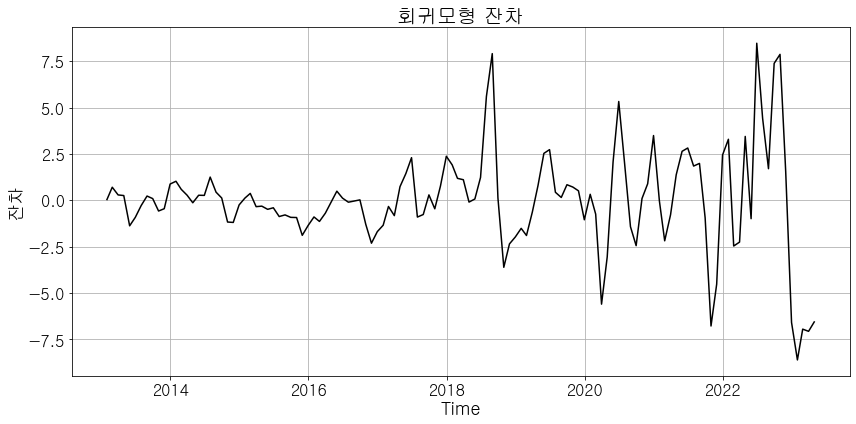

In [60]:
residuals = pd.read_csv('res.csv')
residuals = residuals['x'].tolist()

time_range = pd.date_range(start='2013-01-01', end='2023-05-01', freq='M')
plt.figure(figsize=(12, 6))

plt.plot(time_range, residuals, label='잔차', color='black')
plt.xlabel('Time', fontsize=18)
plt.ylabel('잔차', fontsize=18)
plt.title('회귀모형 잔차', fontsize=20)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

<Figure size 864x432 with 0 Axes>

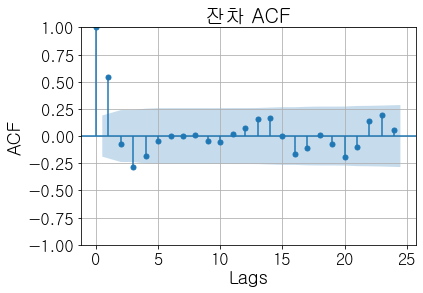

In [13]:
# ACF
plt.figure(figsize=(12, 6))
plot_acf(np.array(residuals), lags=24)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('ACF', fontsize=18)
plt.title('잔차 ACF', fontsize=20)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 864x432 with 0 Axes>

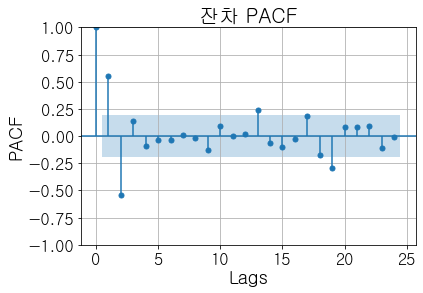

In [14]:
# PACF
plt.figure(figsize=(12, 6))
plot_pacf(np.array(residuals), lags=24)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('PACF', fontsize=18)
plt.title('잔차 PACF', fontsize=20)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [62]:
model = ARIMA(residuals, order=(2, 0, 1))
model_fit = model.fit()
#test_residual_prediction = model_fit.forecast(steps=17).tolist()
#forecast, stderr, conf_int = 
model_fit.forecast(steps=10, alpha=0.05)
#train_residual_prediction = model_fit.predict().tolist()

#residual_prediction = train_residual_prediction + test_residual_prediction

array([-3.11159172, -0.64568339,  0.03089948,  0.05575577, -0.00525656,
       -0.03362394, -0.03914435, -0.0384756 , -0.03761008, -0.03731559])

In [21]:
lr_fit = pd.read_csv('predict.csv')
lr_fit = lr_fit['x'].values

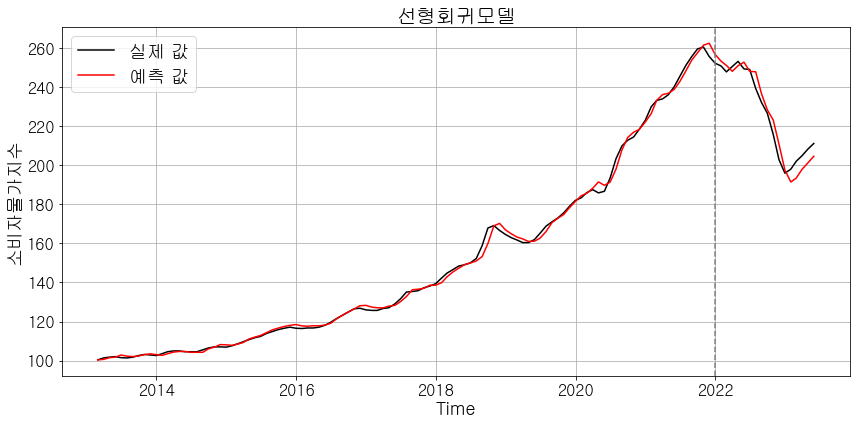

In [58]:
lr_prediction# = lr_fit + np.array(residual_prediction)

result_plot('2013-02-01', '2023-06-01', '2022-01-01', data['아파트 매매 실거래가격지수'][1:], lr_prediction, "선형회귀")

In [93]:
data

,아파트 매매 실거래가격지수,아파트 주택전세가격지수,M1 유동성,기준금리,경기선행지수
0,100.000,100.000,100.000,2.75,100.000
1,100.414,100.576,100.973,2.75,100.136
2,101.381,101.295,101.462,2.75,100.305
3,101.796,101.727,102.838,2.75,100.465
4,102.072,101.871,103.035,2.50,100.587
...,...,...,...,...,...
120,197.928,127.770,260.584,3.50,99.417
121,201.934,123.453,259.061,3.50,99.362
122,204.834,121.007,257.754,3.50,99.395
123,208.149,120.144,257.047,3.50,99.490


In [70]:
lr_conf_int = pd.read_csv('conf_int.csv')
lr_lower = np.array(lr_conf_int['lwr'])
lr_upper = np.array(lr_conf_int['upr'])
arima_conf_int = pd.read_csv('res_arima.csv')
arima_lower = np.array(arima_conf_int['lower'])
arima_upper = np.array(arima_conf_int['upper'])
arima_fit = np.array(arima_conf_int['mean'])
lower = lr_lower + arima_lower
upper = lr_upper + arima_upper
prediction = np.array(lr_prediction[-17:]) + arima_fit

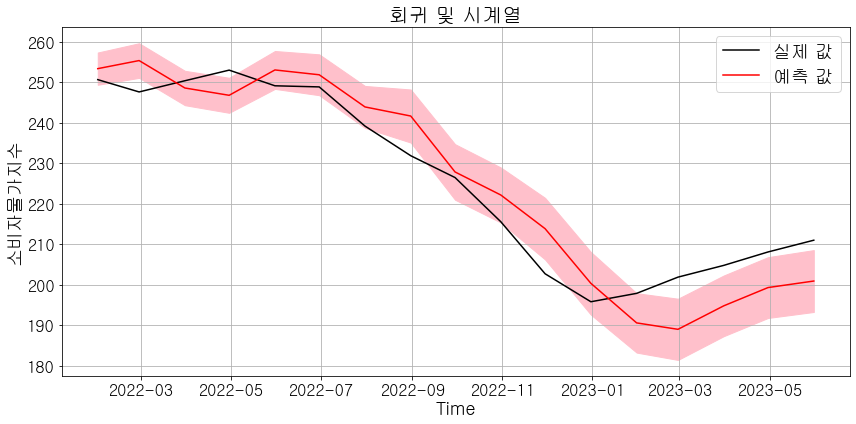

In [73]:
lr_prediction = pd.read_csv('All predict.csv')
lr_prediction = lr_prediction['x'].tolist()


time_range = pd.date_range(start='2013-02-01', end='2023-06-01', freq='M')
    
# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 그래프 그리기
plt.plot(time_range[-17:], data['아파트 매매 실거래가격지수'][-17:], label='실제 값', color='black')
plt.plot(time_range[-17:], prediction, label='예측 값', color='red')
plt.fill_between(time_range[-17:], lower, upper, color='pink')

# 축 제목, 크기 설정
plt.xlabel('Time', fontsize=18)
plt.ylabel('소비자물가지수', fontsize=18)
plt.title('회귀 및 시계열', fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

# 그래프 보이기
plt.show()

In [97]:
score(data['아파트 매매 실거래가격지수'][1:], lr_prediction)

(2.7065, 1.7731)

In [23]:
rmse, mae = score(test['ASPI'].tolist(), lr_prediction[-17:])
print('RMSE:', rmse)
print('MAE:', mae)

RMSE: 18.0653
MAE: 13.9236


## 4.2 RNN 모델 예측 결과 출력 및 시각화

In [220]:
rmse, mae = score(data['아파트 매매 실거래가격지수'][-17:], rnn_prediction[-17:])
print('RNN 모델 test set에서의 RMSE:', rmse)
print('RNN 모델 test set에서의 MAE:', mae)

RNN 모델 test set에서의 RMSE: 7.6833
RNN 모델 test set에서의 MAE: 6.4589


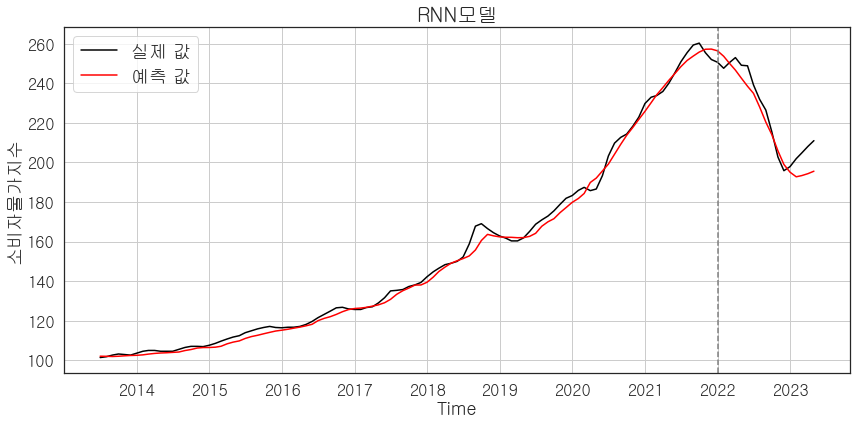

In [221]:
# 전체 구간
start = datetime.strptime('2013-01-01', '%Y-%m-%d') + timedelta(days=30.44 * (seq_length - 1))
start = start.strftime('%Y-%m-%d')
result_plot(start, '2023-05-01', '2022-01-01', data['아파트 매매 실거래가격지수'][seq_length:], rnn_prediction, 'RNN')

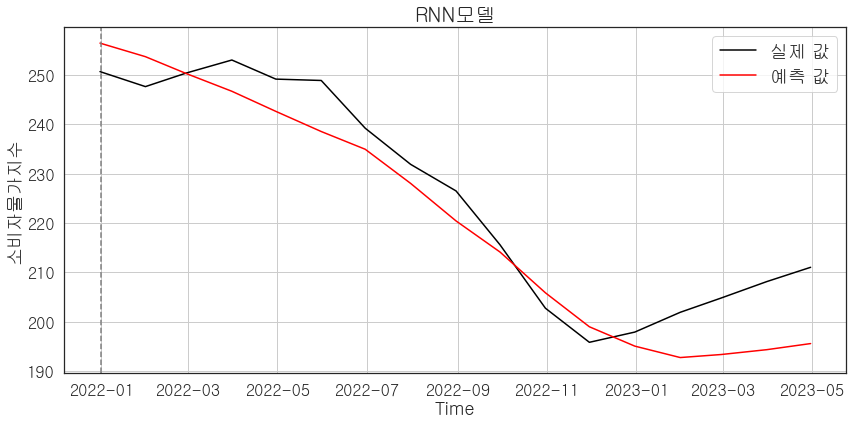

In [222]:
# 예측 구간
result_plot('2021-12-01', '2023-05-01', '2022-01-01', data['아파트 매매 실거래가격지수'][-17:], rnn_prediction[-17:], 'RNN')